In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import(
    load_excel, 
    load_odin_as_ml_dataset, 
    plot_confusion_matrix, 
    make_ml_dataset, 
    run_binary_regression, 
    transport_modes, 
    trip_motives, 
    province_codes, 
    transport_mode_col, 
    IGNORE_RULES, 
    apply_ignore_rules,
    number_of_sub_trips_col,
    id_col
    )

%load_ext autoreload
%autoreload 2

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [3]:
years = [2019, 2020, 2021, 2022, 2023]
dfs = []
for year in years:
    odin_excel_path = os.path.join(os.getcwd(), "data", "OdiN 2019-2023", f"OdiN {year}", f"ODiN{year}_Databestand.csv")
    if year in [2019, 2020]:
        odin_excel_path = odin_excel_path.replace("Databestand", "Databestand_v2.0")
    df = load_excel(odin_excel_path)
    # df = apply_ignore_rules(df, IGNORE_RULES)   # <<–– new line

    dfs.append(df[df[number_of_sub_trips_col] == 1])  # Filter for single sub-trips

df_all = pd.concat(dfs, ignore_index=True, join="inner")
# Convert 'ActDuur' to numeric, handling errors by coercing NaN to 0
df_all['ActDuur'] = pd.to_numeric(df_all['ActDuur'], errors='coerce').fillna(0)

Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV
Loaded file from CSV


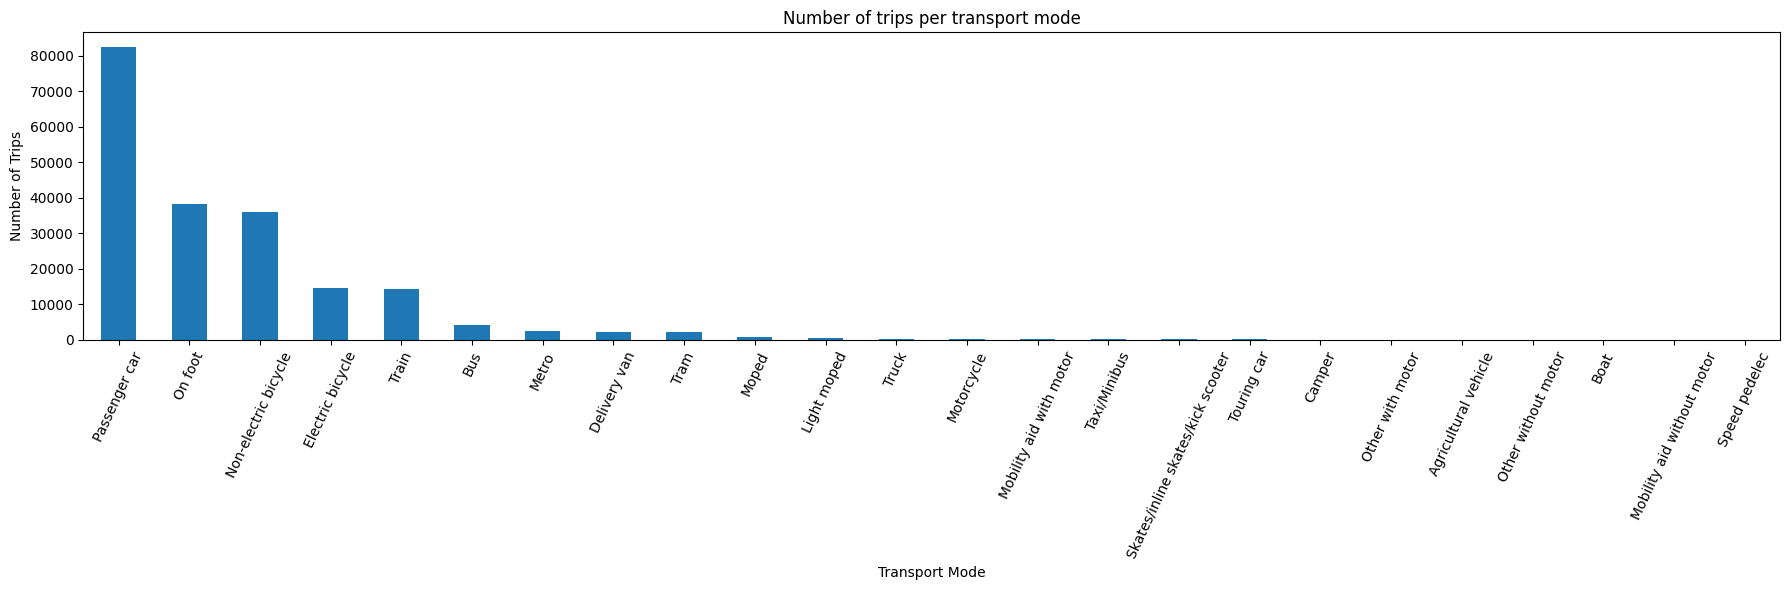

In [4]:
# Create a histogram for the number of trips for each transport mode and translate to 
ax = df[transport_mode_col].value_counts().plot(kind="bar", title="Number of trips per transport mode", figsize=(18, 6))

ax.set_xticklabels([transport_modes.get(int(float(label.get_text())), label.get_text()) for label in ax.get_xticklabels()], rotation=65)

plt.xlabel("Transport Mode")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.savefig("graphics/transport_modes_histogram.png", dpi=300)
plt.show()

Now a classifier that classifies what mode of transport was used

Common labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.4s finished


                                   precision    recall  f1-score   support

                    Passenger car       0.86      0.22      0.36     70167
                            Train       0.12      0.81      0.20       325
                              Bus       0.13      0.60      0.21       670
                             Tram       0.12      0.79      0.20       363
                            Metro       0.07      0.40      0.12       199
                    Speed pedelec       0.00      0.00      0.00        11
                 Electric bicycle       0.36      0.78      0.49     10240
             Non-electric bicycle       0.62      0.43      0.51     33452
                          On foot       0.76      0.42      0.54     34736
                      Touring car       0.03      0.16      0.05       117
                     Delivery van       0.11      0.51      0.18      2199
                            Truck       0.96      0.56      0.70       203
                        

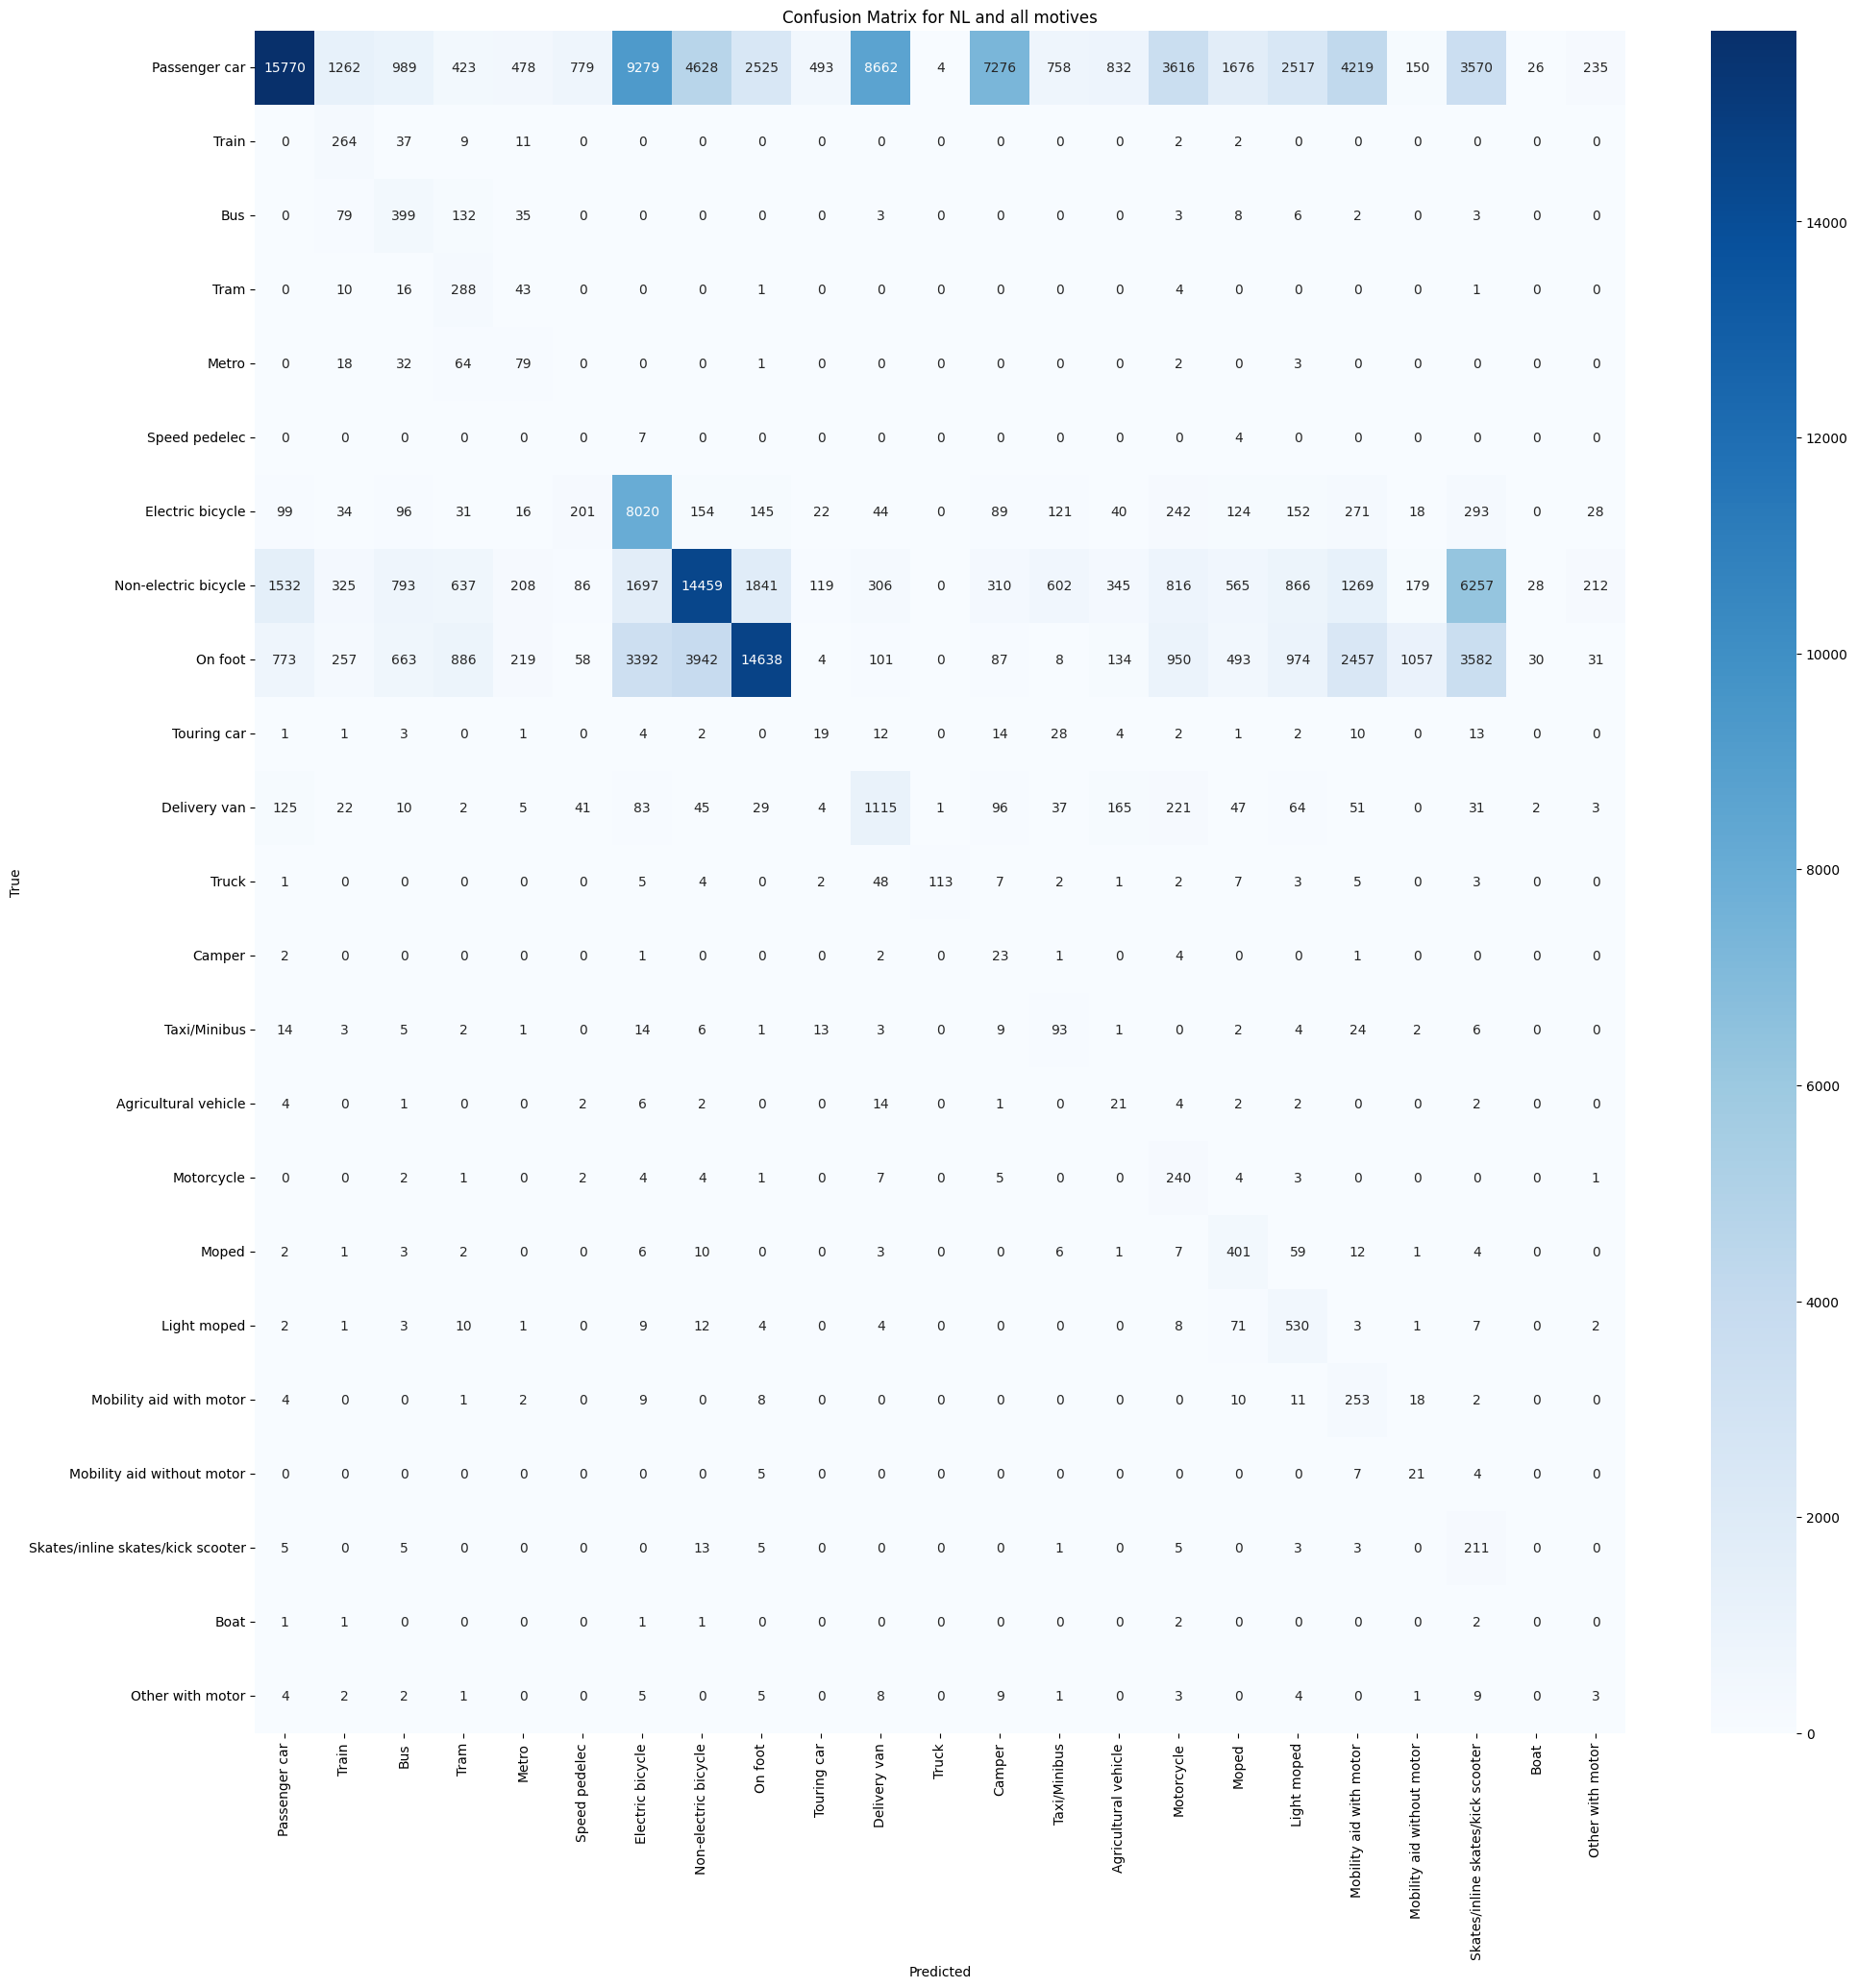

In [5]:
from codebase import (run_multiclass_classification,
                      distance_col, 
                      origin_col, 
                      province_codes, 
                      level_mapping_suffix, 
                      age_col, 
                      transport_mode_col, 
                      motive_col, 
                      urbanness_col,
                      categorical_cols)


df_multiclass = df_all[df_all[transport_mode_col] != df_all[transport_mode_col].max()]
motives=None
origins=None#[7, 8, ]
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_all, (X_train_all, _, _, _), accuracy = run_multiclass_classification(
    df_multiclass,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/full",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
    verbose=True,
)

In [6]:
def get_feature_importances(feature_importances, column_names, top_n_for_plot=100, savename=None):
    """
    Feature importances for multiclass classification.
    """
    importances = pd.Series(feature_importances, index=column_names)
    
    # Group by base feature name (e.g., col_1 from col_1.0, col_1.1)
    grouped = importances.groupby(lambda x: x.split('_')[0]).sum()
    top_features = grouped.sort_values(ascending=False)[:top_n_for_plot]
    num_features = len(grouped)
    num_plotted_features = min(num_features, top_n_for_plot)

    top_features.plot(kind="bar", figsize=(14, 6))
    plt.title(f"Top {num_plotted_features}/{num_features} Feature Importances for Multiclass Classification")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.xticks(rotation=65)
    if savename:
        plt.savefig(savename)
    plt.show()
    
    return grouped

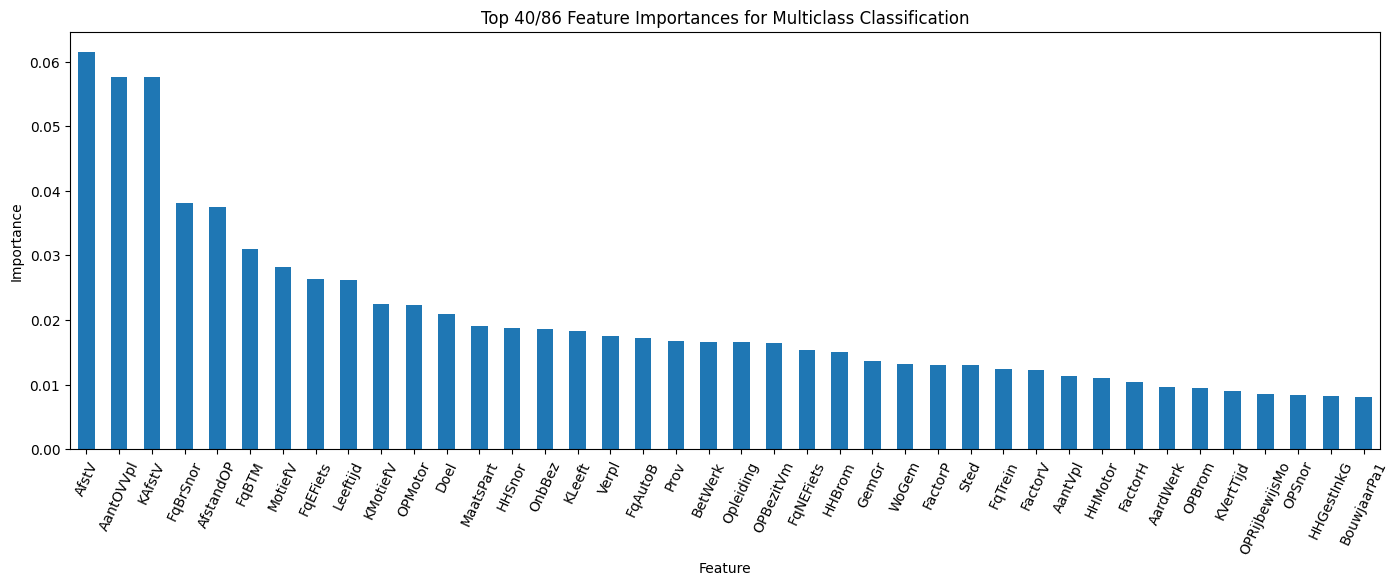

AantOVVpl     0.057649
AantSVpl      0.002021
AantVpl       0.011345
AardWerk      0.009572
ActDuur       0.007132
                ...   
Verpl         0.017607
VertLoc       0.007735
VolgWerk      0.004855
Weggeweest    0.000017
WoGem         0.013228
Length: 86, dtype: float64

In [7]:
get_feature_importances(pipeline_all["model"].feature_importances_, top_n_for_plot=40, column_names=X_train_all.columns, savename=f"graphics/classification_results/multiclass/feature_importances_all.png")

In [8]:
from codebase import urbanness_col, motive_col

age_range = (0, np.inf)
vehicles_to_include = [1, 7, 8, 9, ]

df_less_vehicles = df_multiclass[df_multiclass[transport_mode_col].isin(vehicles_to_include)]
df_less_vehicles: pd.DataFrame = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     70523
    Electric bicycle       0.40      0.91      0.55     10541
Non-electric bicycle       0.64      0.77      0.70     33669
             On foot       0.83      0.68      0.75     34802

            accuracy                           0.74    149535
           macro avg       0.69      0.77      0.70    149535
        weighted avg       0.79      0.74      0.75    149535



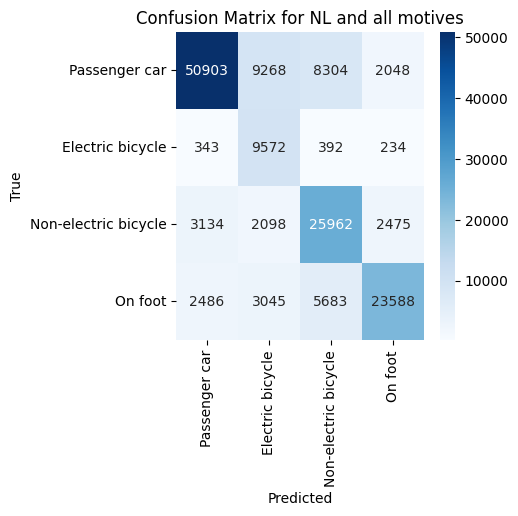

In [9]:
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_less, (X_train_less, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

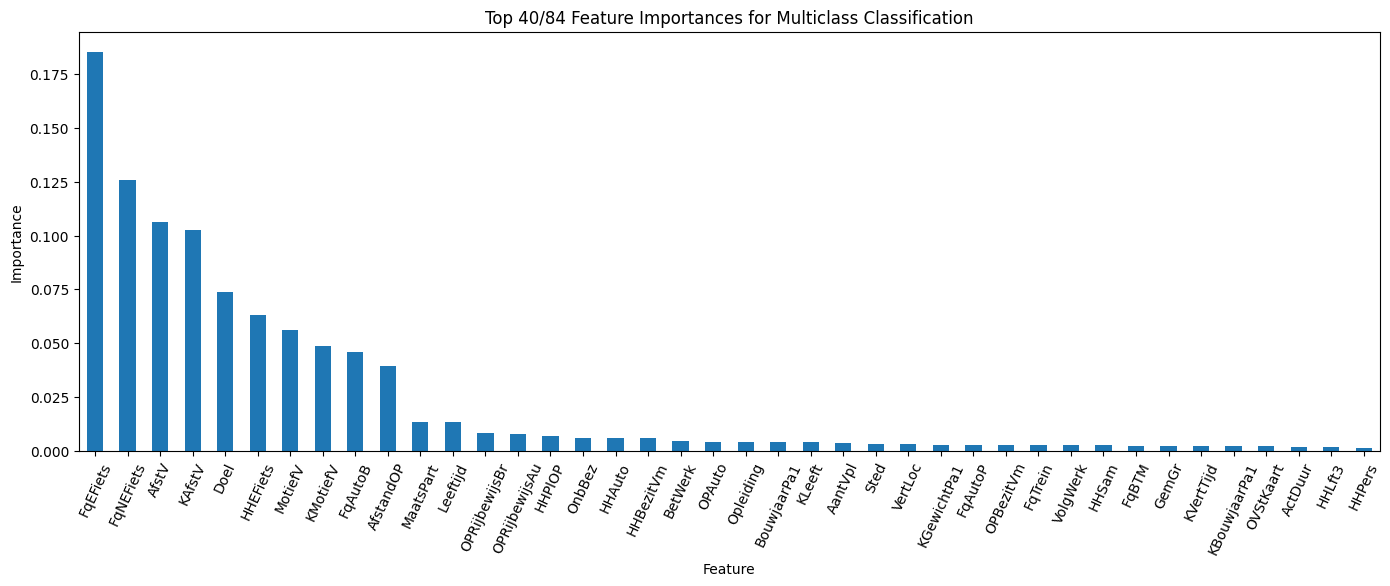

In [10]:
grouped_importances_less = get_feature_importances(pipeline_less["model"].feature_importances_, column_names=X_train_less.columns, top_n_for_plot=40, savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles.png")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier


class SktorchNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[64], dtype=torch.float64):
        super(SktorchNN, self).__init__()
        layers = []
        for size in hidden_layers:
            layers.append(nn.Linear(input_dim, size, dtype=dtype))
            layers.append(nn.ReLU())
            input_dim = size
        layers.append(nn.Linear(size, output_dim, dtype=dtype))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [12]:
X_train_less.columns[np.where(X_train_less.isna().sum(axis=0))]

Index([], dtype='object')

In [18]:
from codebase import run_multiclass_classification
from skorch.callbacks import Checkpoint

save_path = "neural_net_checkpoints"
os.makedirs(save_path, exist_ok=True)
checkpoint = Checkpoint(monitor='valid_loss_best', f_params='best_model.pt')
early_stopping = Checkpoint(monitor='valid_loss_best', f_patience=2, f_params='best_model.pt')
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

lr = 0.001
input_dim=X_train_less.shape[1]
output_dim=len(vehicles_to_include)
hidden_layers=[500, 200, 100]
max_epochs=5

net = NeuralNetClassifier(
    SktorchNN(input_dim=input_dim, output_dim=output_dim, hidden_layers=hidden_layers),
    max_epochs=max_epochs,
    lr=lr,
    batch_size=32,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss(),
    verbose=1,
    device=device,
    callbacks=[checkpoint, early_stopping],
)

pipeline_less, (X_train_less, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    model=net,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/neural_net/less_vehicles",
    plot_title=f"Confusion Matrix for Neural Network on {origin_str} and {motive_str}",
    y_translation={val: order for order, val in enumerate(vehicles_to_include)},
)

Using device: cuda
Common labels: [0 1 2 3]
  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        0.5656       0.7840        0.5316     +  45.7641
      2        0.5063       0.7874        0.5187     +  48.8550
      3        0.4934       0.7885        0.5129     +  50.2836
      4        0.4858       0.7924        0.5092     +  49.5309
      5        0.4794       0.7923        0.5089     +  49.4151


AttributeError: 'numpy.ndarray' object has no attribute 'unique'

Now keep the top N

In [ ]:
"Hvm" in df_less_vehicles.columns

True

Keeping 86 columns after dropping 116 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     70523
    Electric bicycle       0.40      0.91      0.55     10541
Non-electric bicycle       0.64      0.77      0.70     33669
             On foot       0.83      0.68      0.75     34802

            accuracy                           0.74    149535
           macro avg       0.69      0.77      0.70    149535
        weighted avg       0.79      0.74      0.75    149535



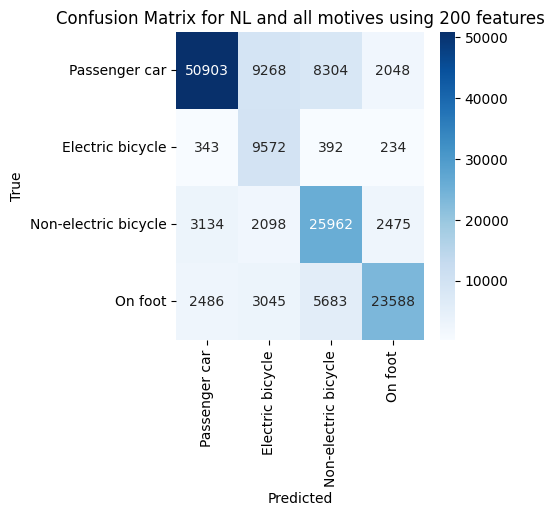

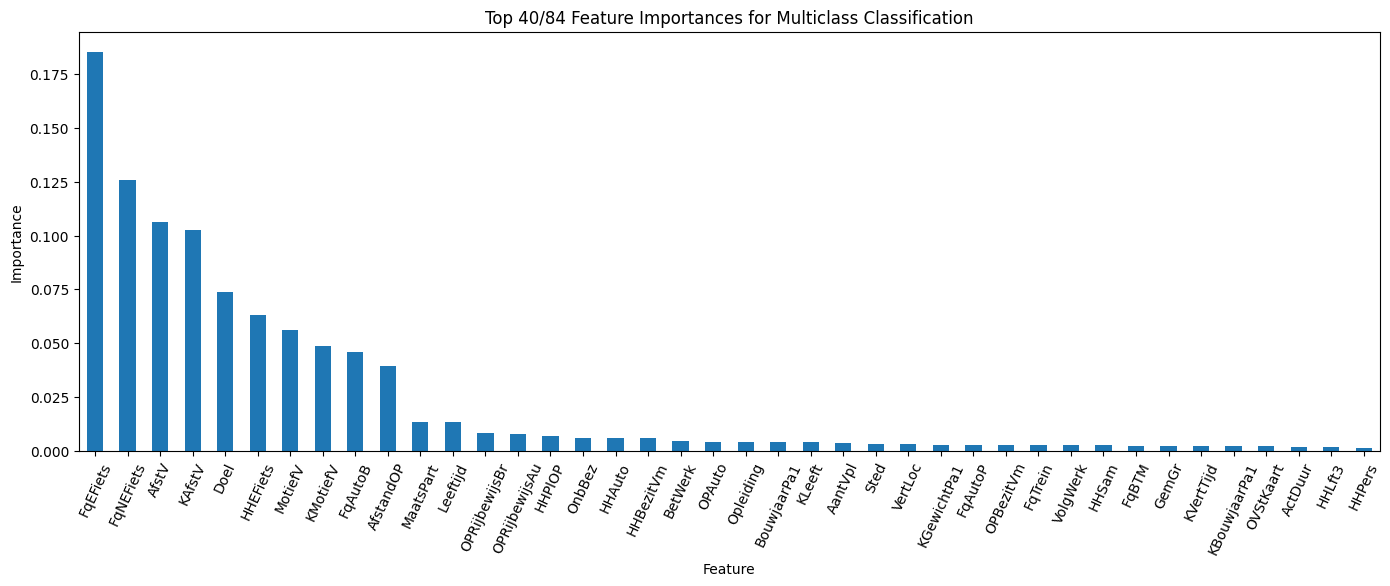

Keeping 86 columns after dropping 116 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     70523
    Electric bicycle       0.40      0.91      0.55     10541
Non-electric bicycle       0.64      0.77      0.70     33669
             On foot       0.83      0.68      0.75     34802

            accuracy                           0.74    149535
           macro avg       0.69      0.77      0.70    149535
        weighted avg       0.79      0.74      0.75    149535



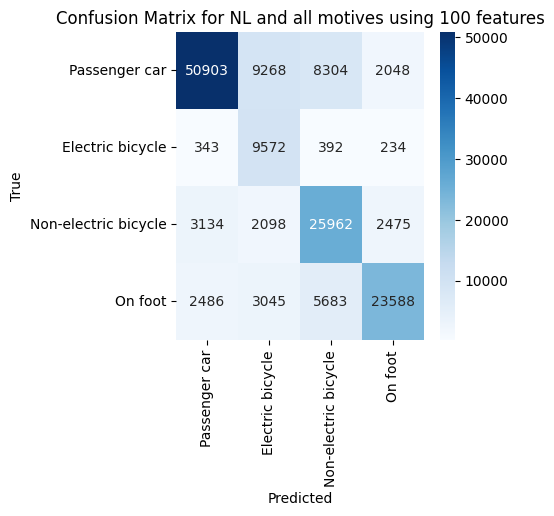

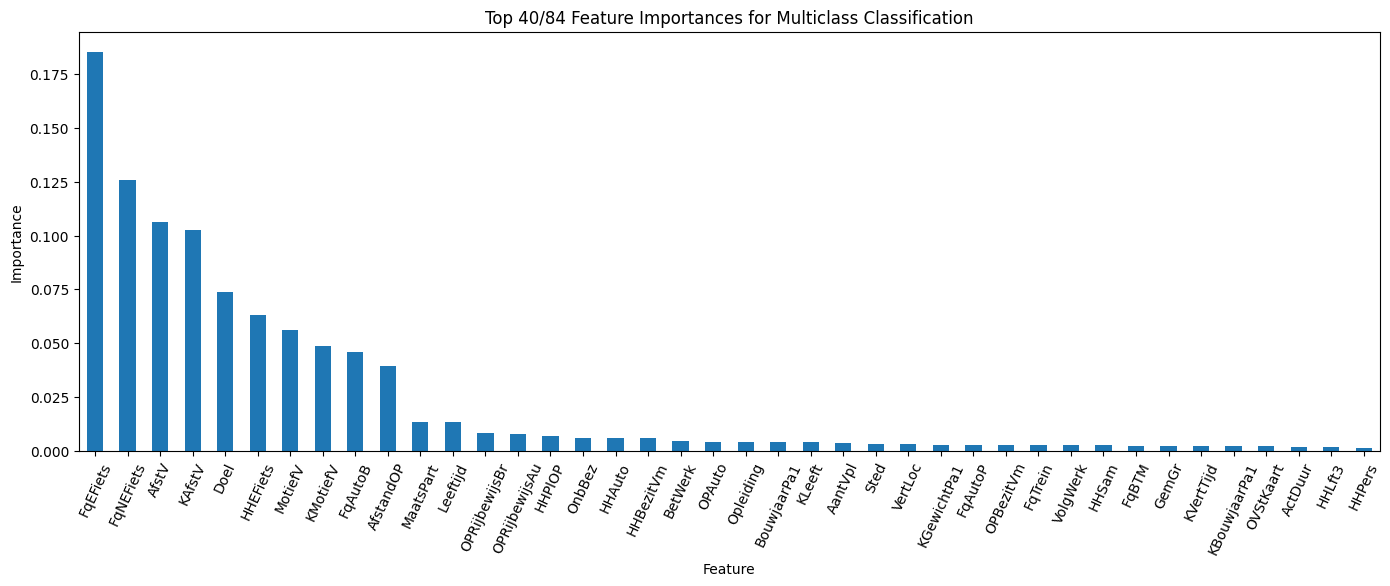

Keeping 52 columns after dropping 150 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.72      0.80     70523
    Electric bicycle       0.41      0.90      0.56     10541
Non-electric bicycle       0.64      0.77      0.70     33669
             On foot       0.82      0.70      0.76     34802

            accuracy                           0.74    149535
           macro avg       0.69      0.77      0.71    149535
        weighted avg       0.79      0.74      0.75    149535



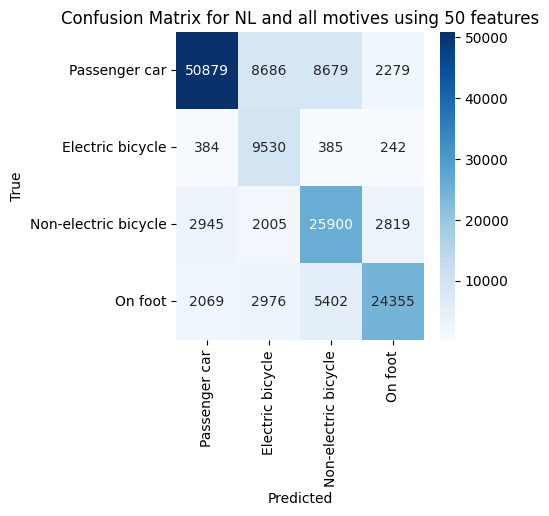

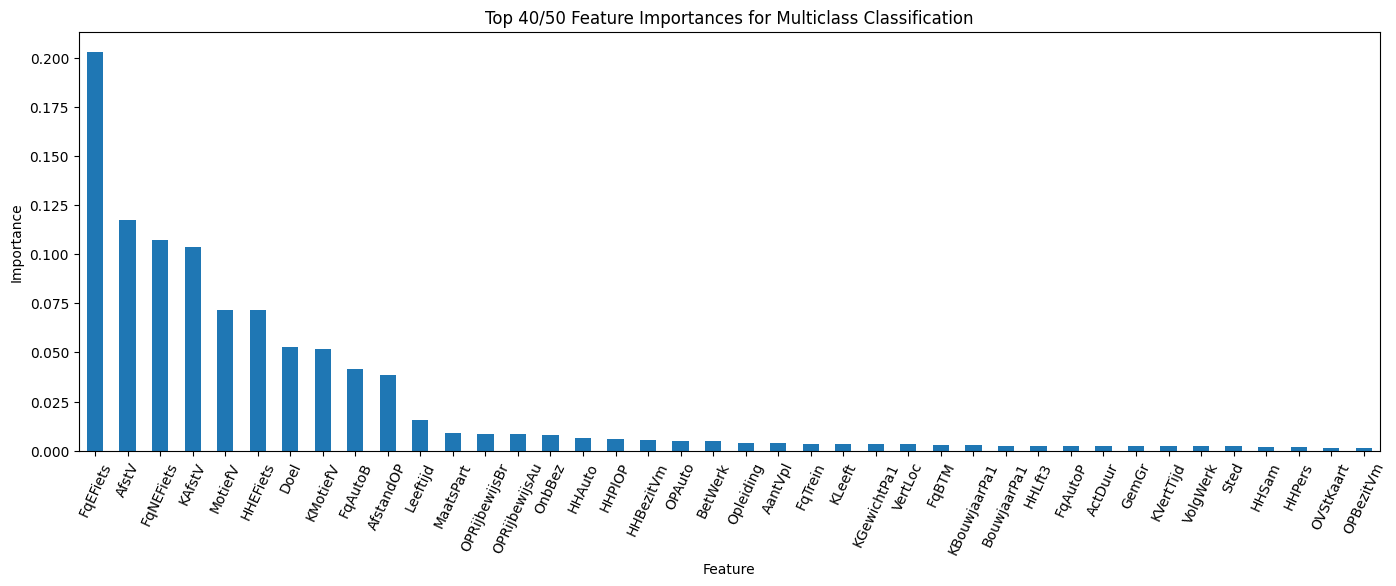

Keeping 27 columns after dropping 175 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.1s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.72      0.80     70523
    Electric bicycle       0.41      0.90      0.57     10541
Non-electric bicycle       0.64      0.78      0.70     33669
             On foot       0.82      0.71      0.76     34802

            accuracy                           0.74    149535
           macro avg       0.70      0.78      0.71    149535
        weighted avg       0.79      0.74      0.75    149535



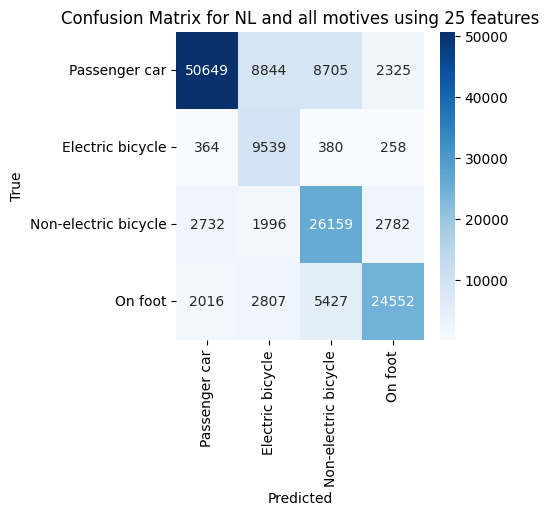

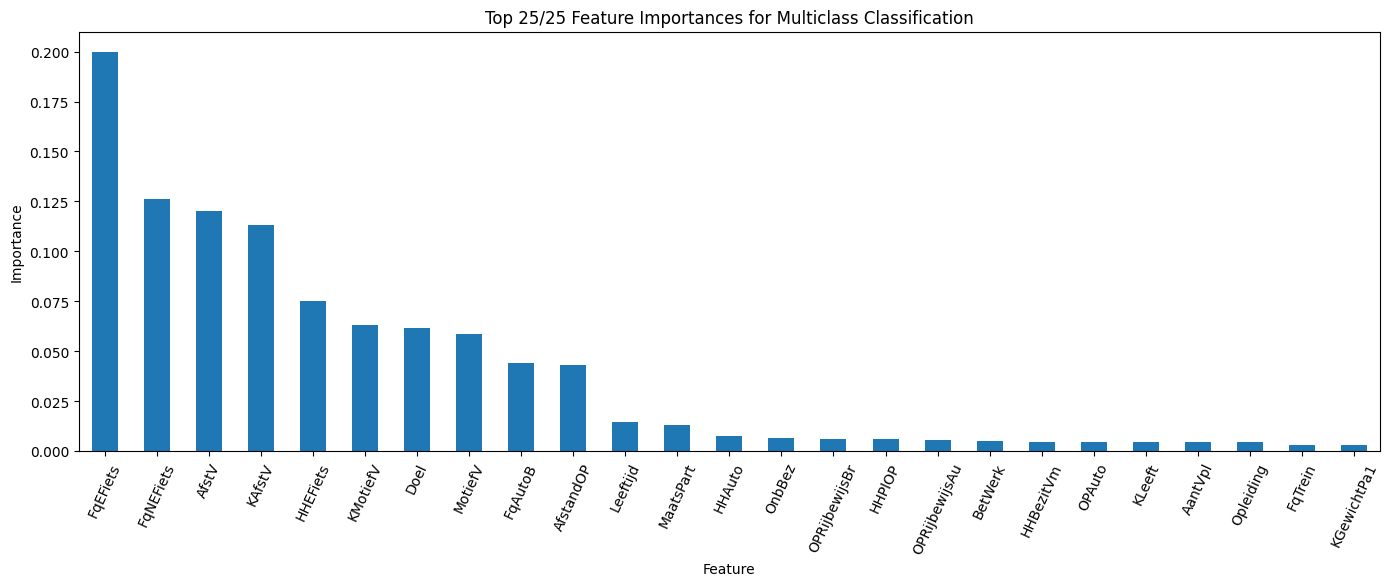

Keeping 17 columns after dropping 185 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.92      0.72      0.80     70523
    Electric bicycle       0.42      0.91      0.57     10541
Non-electric bicycle       0.65      0.78      0.71     33669
             On foot       0.82      0.72      0.77     34802

            accuracy                           0.74    149535
           macro avg       0.70      0.78      0.71    149535
        weighted avg       0.80      0.74      0.76    149535



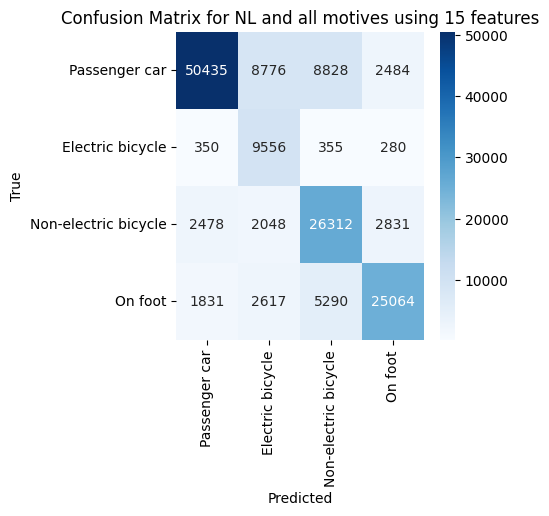

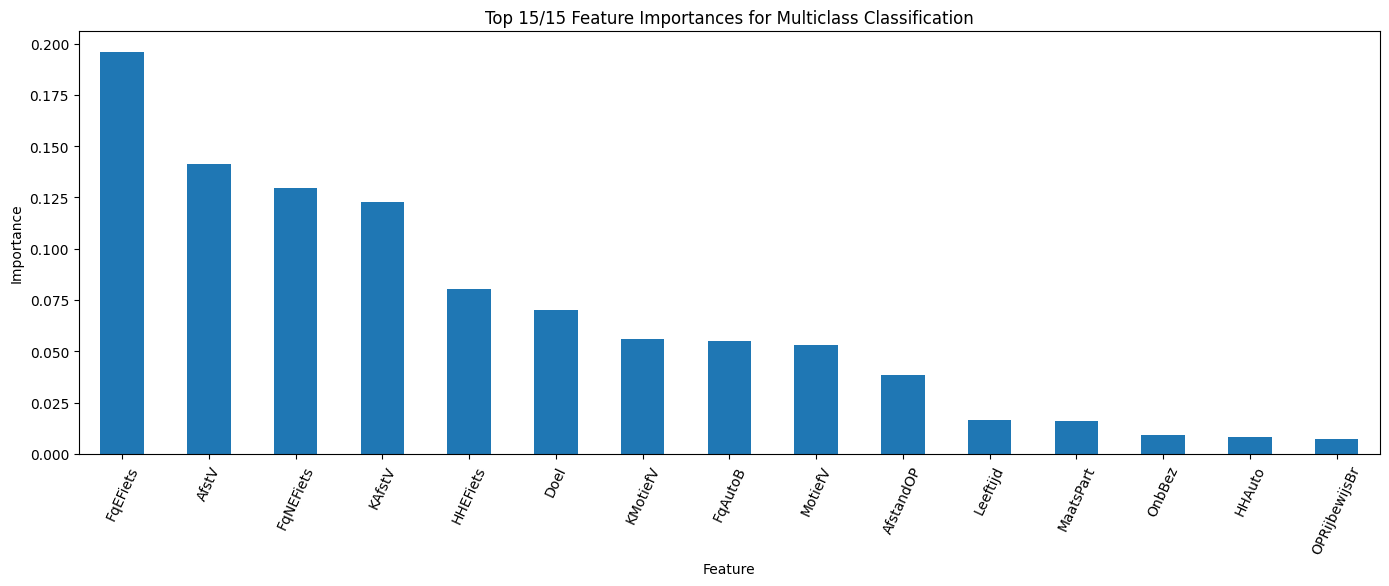

Keeping 12 columns after dropping 190 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.92      0.72      0.80     70523
    Electric bicycle       0.43      0.90      0.58     10541
Non-electric bicycle       0.64      0.79      0.71     33669
             On foot       0.81      0.72      0.76     34802

            accuracy                           0.75    149535
           macro avg       0.70      0.78      0.71    149535
        weighted avg       0.80      0.75      0.76    149535



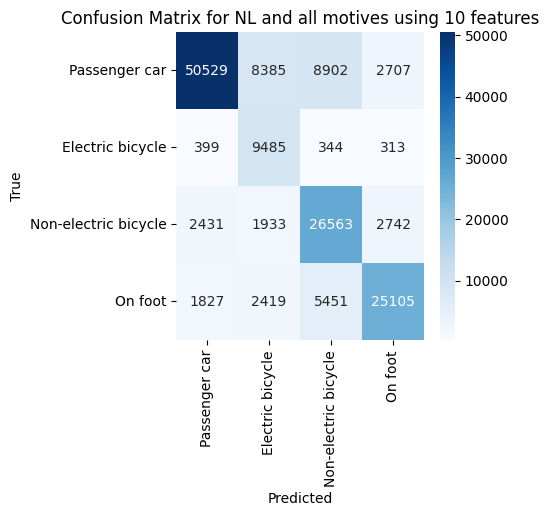

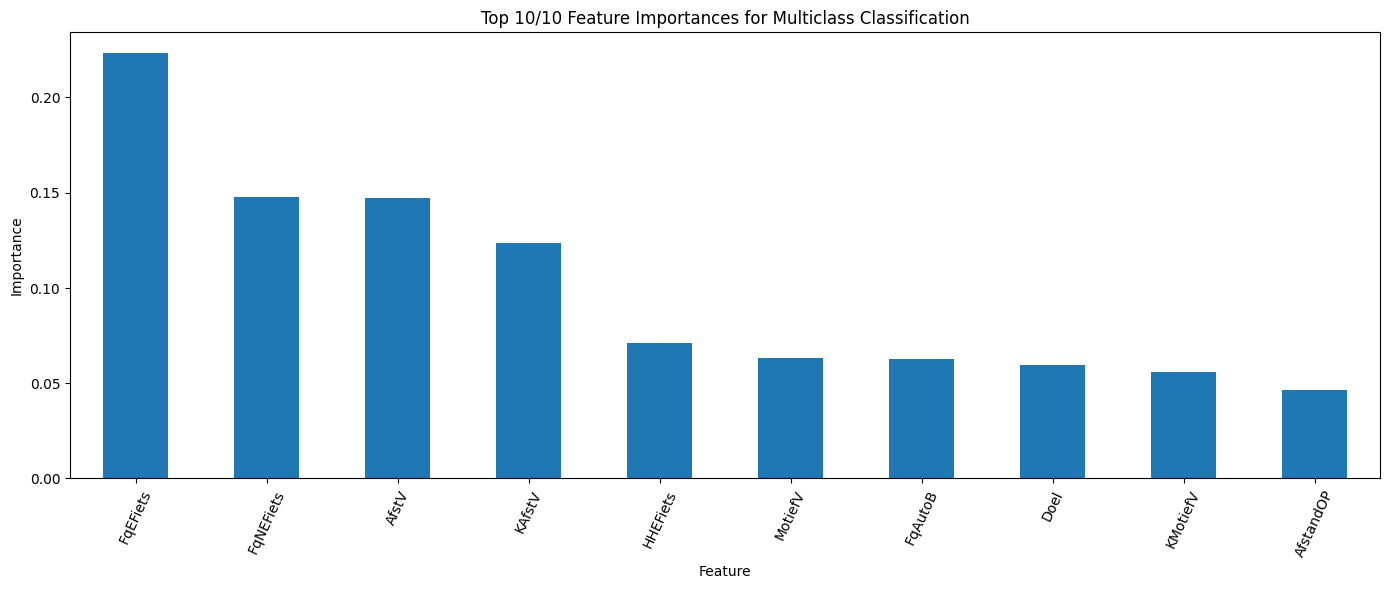

Keeping 10 columns after dropping 192 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.91      0.72      0.80     70523
    Electric bicycle       0.42      0.90      0.58     10541
Non-electric bicycle       0.66      0.77      0.71     33669
             On foot       0.80      0.73      0.76     34802

            accuracy                           0.75    149535
           macro avg       0.70      0.78      0.71    149535
        weighted avg       0.79      0.75      0.76    149535



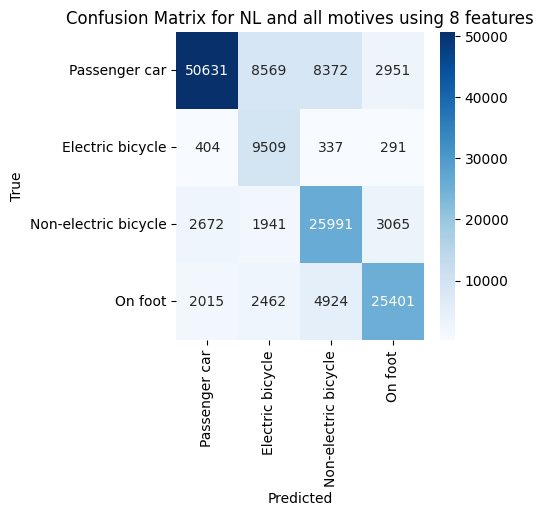

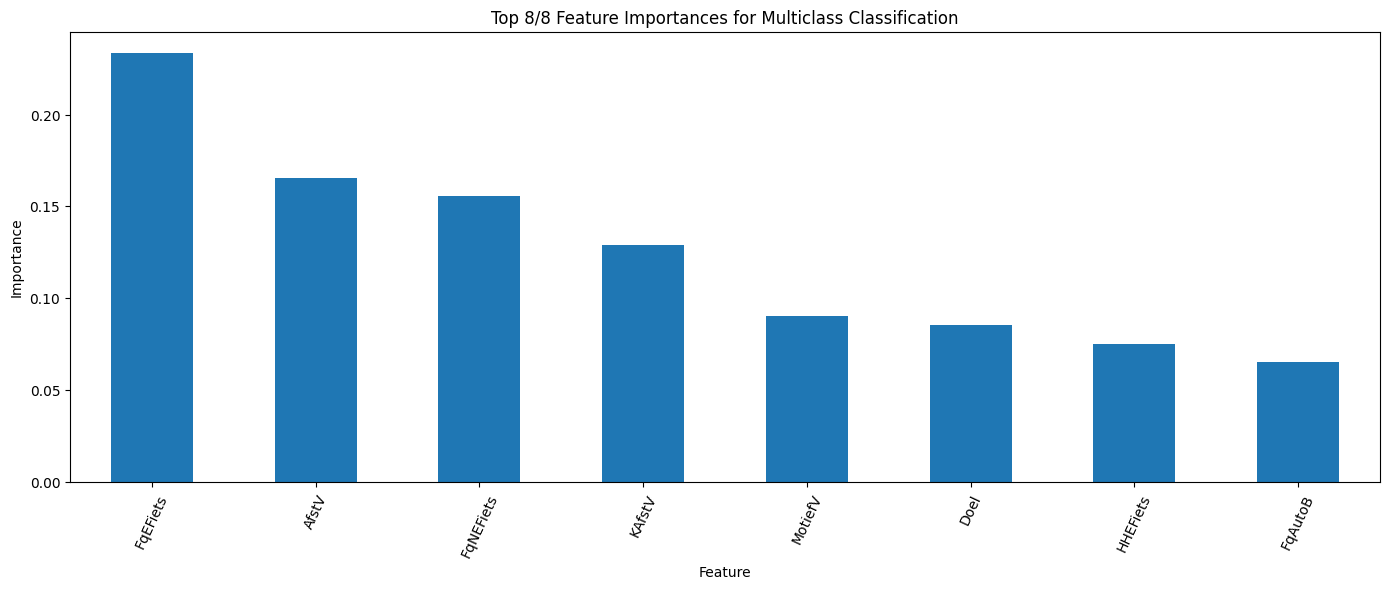

Keeping 7 columns after dropping 195 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.90      0.68      0.78     70523
    Electric bicycle       0.42      0.89      0.57     10541
Non-electric bicycle       0.63      0.79      0.70     33669
             On foot       0.79      0.72      0.75     34802

            accuracy                           0.73    149535
           macro avg       0.69      0.77      0.70    149535
        weighted avg       0.78      0.73      0.74    149535



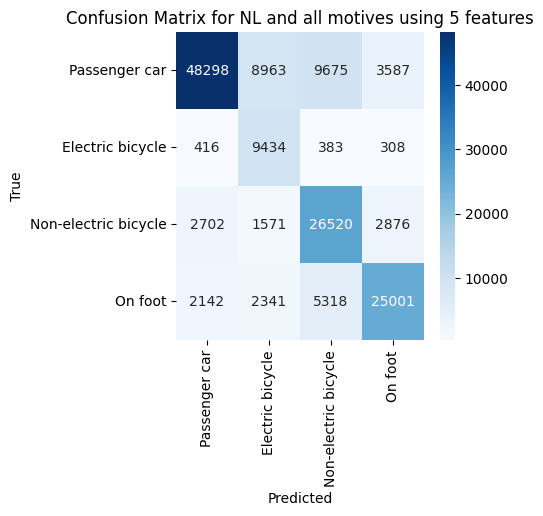

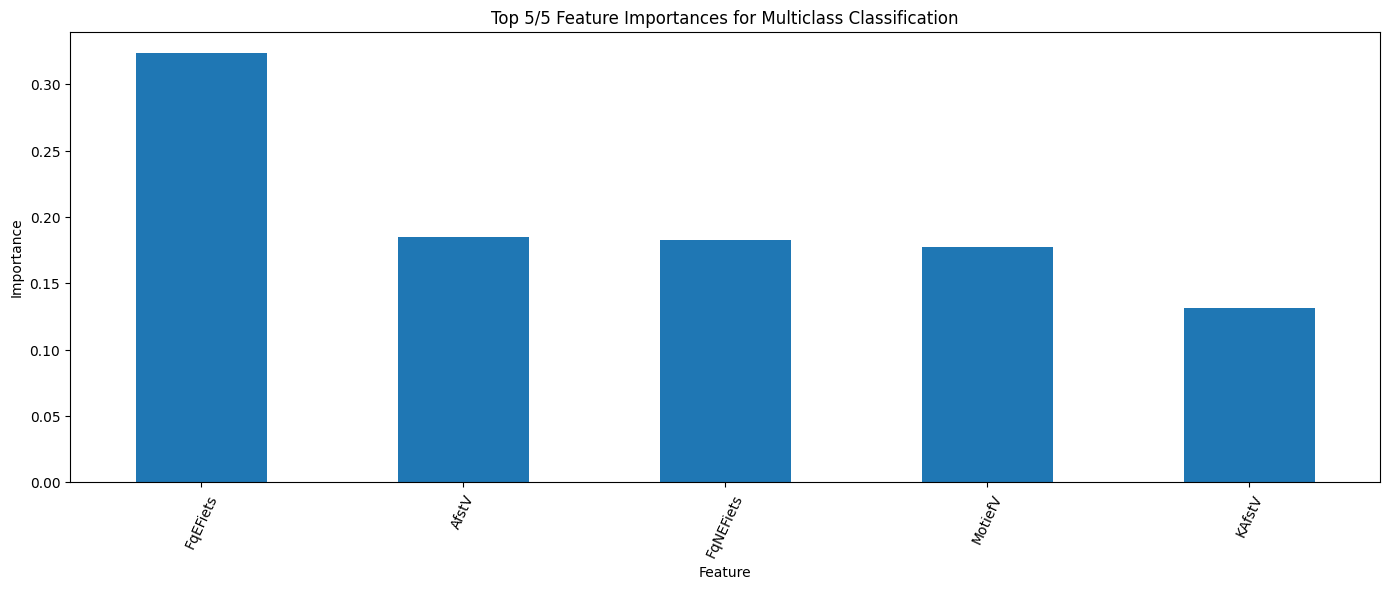

Keeping 6 columns after dropping 196 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.89      0.69      0.78     70523
    Electric bicycle       0.42      0.90      0.57     10541
Non-electric bicycle       0.65      0.77      0.70     33669
             On foot       0.77      0.73      0.75     34802

            accuracy                           0.73    149535
           macro avg       0.68      0.77      0.70    149535
        weighted avg       0.78      0.73      0.74    149535



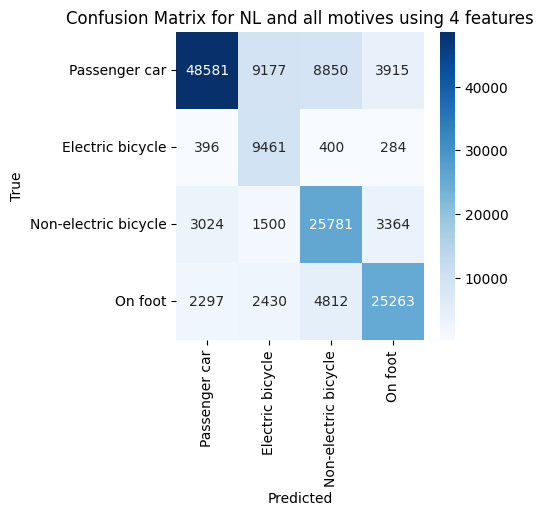

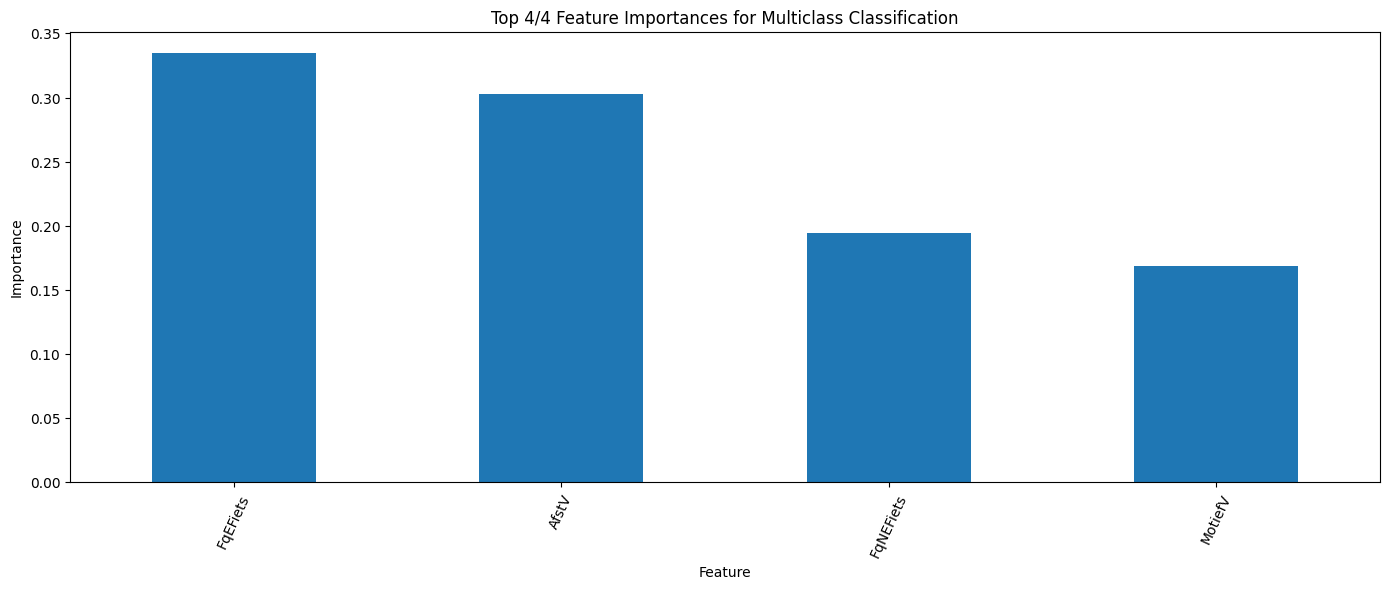

Keeping 5 columns after dropping 197 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.85      0.61      0.71     70523
    Electric bicycle       0.36      0.88      0.51     10541
Non-electric bicycle       0.58      0.77      0.66     33669
             On foot       0.61      0.49      0.55     34802

            accuracy                           0.64    149535
           macro avg       0.60      0.69      0.61    149535
        weighted avg       0.70      0.64      0.65    149535



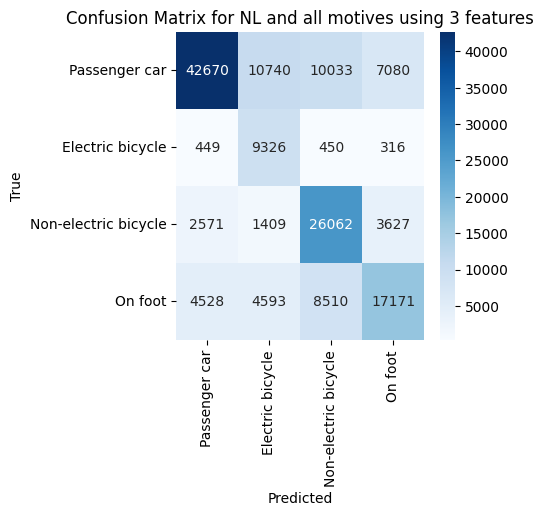

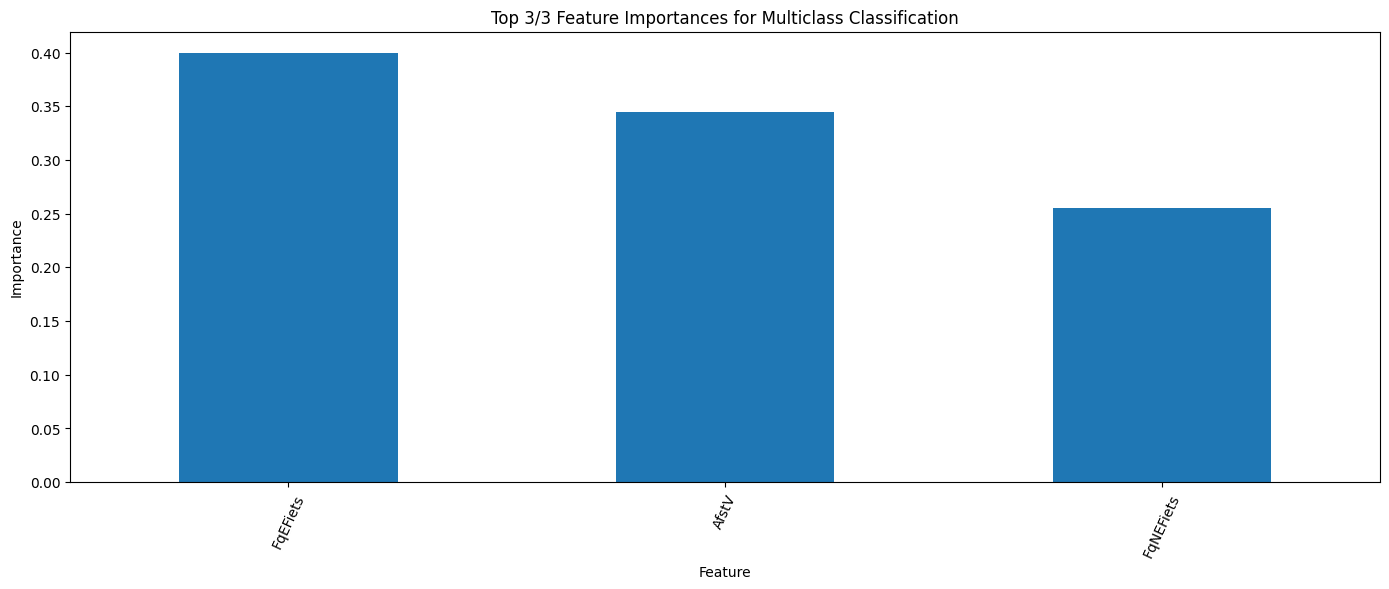

Keeping 4 columns after dropping 198 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'Reisduur'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.80      0.55      0.65     70523
    Electric bicycle       0.34      0.90      0.50     10541
Non-electric bicycle       0.40      0.65      0.50     33669
             On foot       0.68      0.37      0.48     34802

            accuracy                           0.55    149535
           macro avg       0.56      0.62      0.53    149535
        weighted avg       0.65      0.55      0.57    149535



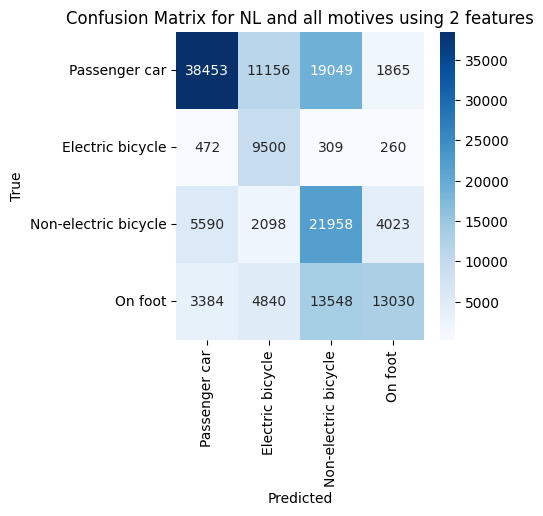

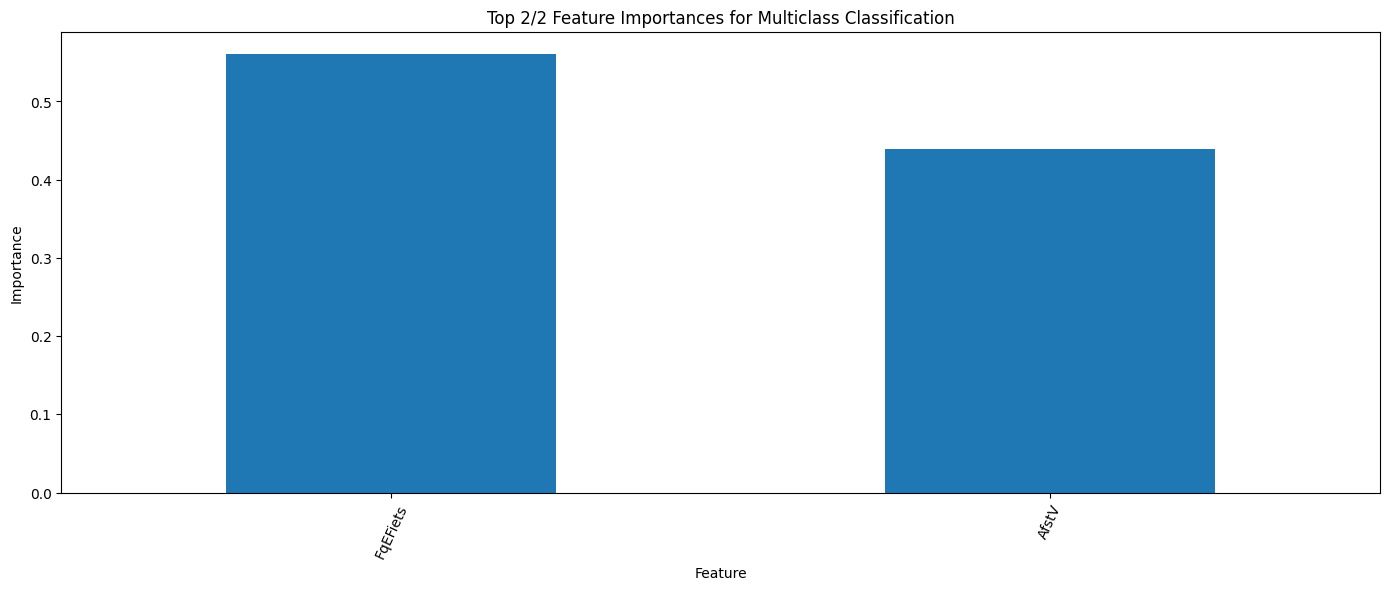

Keeping 3 columns after dropping 199 columns.
Skip filtering by distance and duration: "Column not found in dataframe: 'AfstV'. Ensure the dataframe contains 'AfstV' and 'Reisduur' columns."
Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set

                      precision    recall  f1-score   support

       Passenger car       0.57      0.12      0.20     70523
    Electric bicycle       0.31      0.93      0.47     10541
Non-electric bicycle       0.28      0.85      0.42     33669
             On foot       0.00      0.00      0.00     34802

            accuracy                           0.31    149535
           macro avg       0.29      0.47      0.27    149535
        weighted avg       0.35      0.31      0.22    149535



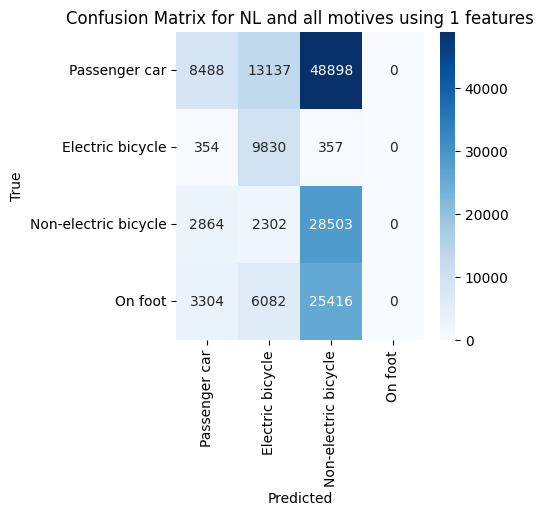

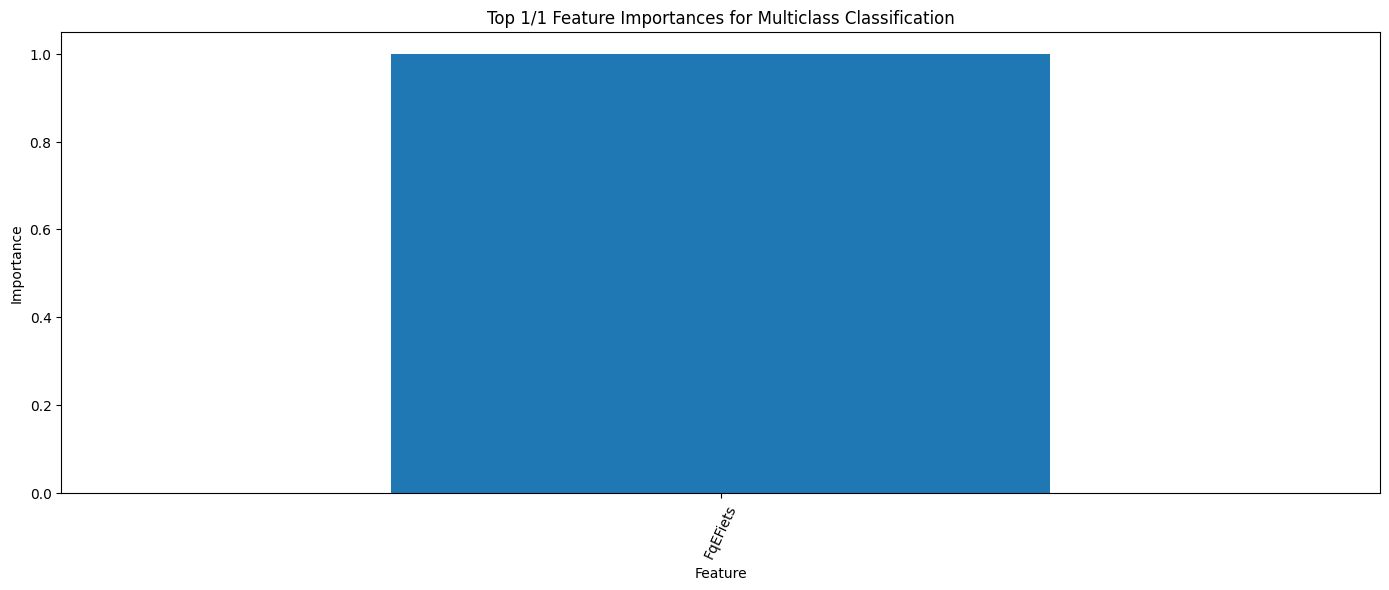

In [11]:
prev_grouped_importances = grouped_importances_less

nums = [200, 100, 50, 25, 15, 10, 8, 5, 4, 3, 2, 1]
accs = []
features_per_num = dict()

for num_keep in nums:
    prev_grouped_importances = prev_grouped_importances.sort_values(ascending=False)[:num_keep]

    cols_to_drop = [col for col in df_less_vehicles.columns if col not in list(prev_grouped_importances.index) + [transport_mode_col, id_col]]
    df_keep_loop = df_less_vehicles.drop(columns=cols_to_drop)
    print(f"Keeping {len(df_keep_loop.columns)} columns after dropping {len(cols_to_drop)} columns.")

    pipeline_keep_loop, (X_train, _, _, _), accuracy = run_multiclass_classification(
        df_keep_loop,
        test_size=0.2,
        destinations=None,
        origins=origins,
        location_level=location_level,
        categorical_features=categorical_cols,
        motives=motives,
        plot=True,
        savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles_{num_keep}",
        plot_title=f"Confusion Matrix for {origin_str} and {motive_str} using {num_keep} features",
        verbose=True,
    )


    prev_grouped_importances = get_feature_importances(
        pipeline_keep_loop["model"].feature_importances_, 
        column_names=X_train.columns, 
        top_n_for_plot=40, 
        savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles_{num_keep}.png"
    )
    accs.append(accuracy)

    features_per_num[num_keep] = prev_grouped_importances

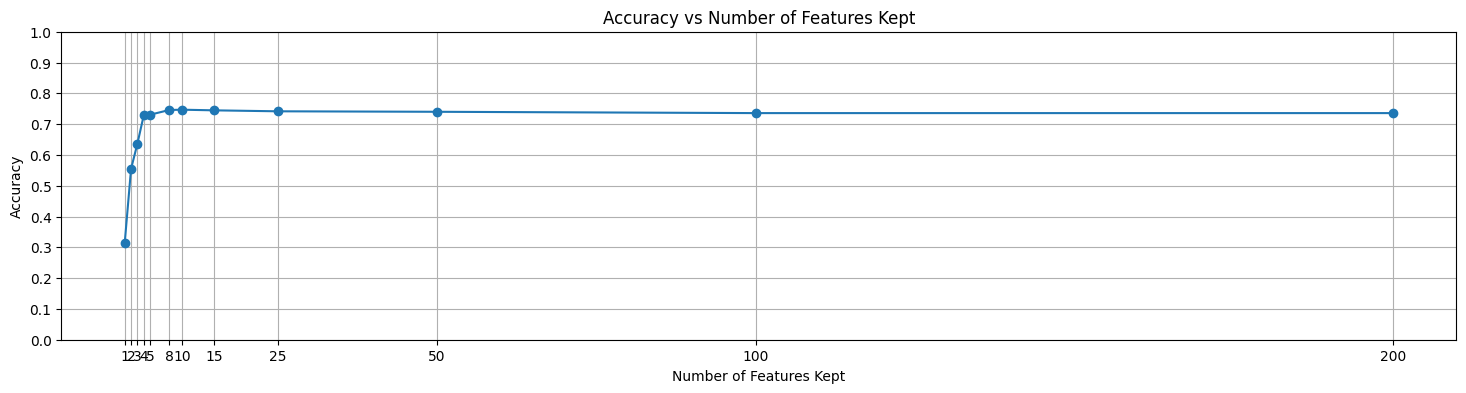

In [12]:
plt.figure(figsize=(18, 4))
plt.plot(nums, accs, marker='o')
plt.title("Accuracy vs Number of Features Kept")
plt.xlabel("Number of Features Kept")
plt.ylabel("Accuracy")
# plt.xscale('log')
plt.xticks(nums)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.savefig("graphics/classification_results/multiclass/accuracy_vs_num_features.png", dpi=300)
plt.show()

Common labels: [1 7 8 9]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


                      precision    recall  f1-score   support

       Passenger car       0.92      0.72      0.80     70523
    Electric bicycle       0.43      0.90      0.58     10541
Non-electric bicycle       0.64      0.79      0.71     33669
             On foot       0.81      0.72      0.76     34802

            accuracy                           0.75    149535
           macro avg       0.70      0.78      0.71    149535
        weighted avg       0.80      0.75      0.76    149535



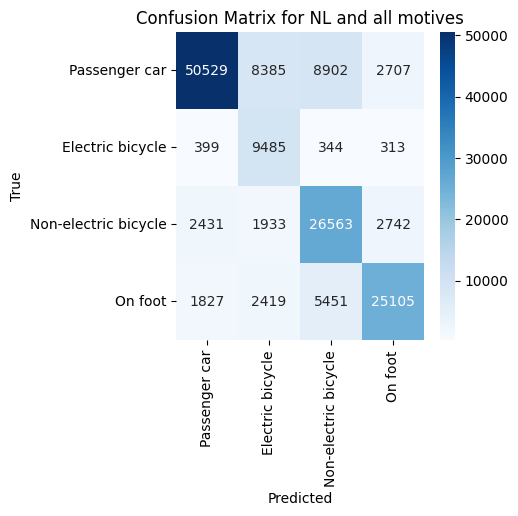

In [13]:
num_to_replicate = 10

# categorical_cols_for_small = [
#     urbanness_col, 
#     age_col,
#     distance_col,
#     motive_col,
#     "KAfstV",
#     "Doel"
# ] 

cols_to_keep = features_per_num[num_to_replicate].index.to_list() + [id_col]
cols_to_drop = [col for col in df_less_vehicles.columns if col not in cols_to_keep + [transport_mode_col]]

pipeline_transferable, (X_train, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    drop_cols=cols_to_drop,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/transferable_forest_{num_to_replicate}",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

In [48]:
from codebase import prepare_odin_stats
df_all["BuurtCode"] = df_all["WoPC"].astype(str).str[:4]  # Extract first 4 characters for BuurtCode
df_all["bu_code"] = df_all["BuurtCode"].astype(str)  # Ensure BuurtCode is 4 digits
stats_df = prepare_odin_stats(df_all)


C:\Users\toell\AppData\Local\Temp\ipykernel_22144\2894094365.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all["bu_code"] = df_all["BuurtCode"].astype(str)  # Ensure BuurtCode is 4 digits


In [49]:
purpose_dict = {
    1: "To home",
    2: "Work",
    3: "Business visit (work-related)",
    4: "Professional",
    5: "Pick up/drop off people",
    6: "Pick up/drop off goods",
    7: "Education/course",
    8: "Shopping/groceries",
    9: "Visit/stay over",
    10: "Touring/walking",
    11: "Sports/hobby",
    12: "Other leisure activity",
    13: "Services/personal care",
    14: "Other purpose"
}

motive_dict = {
    1: "Commute to/from work",
    2: "Business visit (work-related)",
    3: "Professional",
    4: "Pick up/drop off people",
    5: "Pick up/drop off goods",
    6: "Education/course",
    7: "Shopping/groceries",
    8: "Visit/stay over",
    9: "Touring/walking",
    10: "Sports/hobby",
    11: "Other leisure activity",
    12: "Services/personal care",
    13: "Other motive"
}

In [50]:
mask_count = stats_df["Count"] > 100
stats_df_filtered = stats_df[mask_count]
stats_df_filtered.loc[:, "Doel"] = 7
stats_df_filtered.loc[:, "KMotiefV"] = 6
print(len(stats_df_filtered))

2076


In [65]:
stats_df_filtered.loc[:,"bu_code"] = stats_df_filtered["BuurtCode"]

In [66]:
demographics = stats_df_filtered
cols_for_transferable = features_per_num[num_to_replicate].index.to_list()
print(f"Columns for transferable model: {cols_for_transferable}")
print(demographics[cols_for_transferable].head())

Columns for transferable model: ['AfstV', 'AfstandOP', 'Doel', 'FqAutoB', 'FqEFiets', 'FqNEFiets', 'HHEFiets', 'KAfstV', 'KMotiefV', 'MotiefV']
        AfstV   AfstandOP  Doel   FqAutoB  FqEFiets  FqNEFiets  HHEFiets  \
0   50.997059  236.282421   7.0  3.936599  4.541787   2.077810  0.141210   
1   53.324561  229.337719   7.0  4.048246  4.789474   1.964912  0.092105   
2   66.645724  252.092496   7.0  3.752182  4.572426   1.762653  0.125654   
3  108.650000  481.991667   7.0  2.775000  3.616667   2.416667  0.450000   
4   82.522124  350.380531   7.0  3.736283  4.730973   1.881416  0.102655   

     KAfstV  KMotiefV  MotiefV  
0  4.017647       6.0      7.0  
1  4.074561       6.0      7.0  
2  4.373473       6.0      7.0  
3  5.700000       6.0      1.0  
4  4.283186       6.0      7.0  


In [67]:
print(demographics.columns.to_list())

['BuurtCode', 'ActDuur', 'Leeftijd', 'AantVpl', 'AantOVVpl', 'AantSVpl', 'FactorH', 'FactorP', 'FactorV', 'HHPers', 'HHLft1', 'HHLft2', 'HHLft3', 'HHLft4', 'HHRijbewijsAu', 'HHRijbewijsMo', 'HHRijbewijsBr', 'HHAuto', 'HHAutoL', 'OPAuto', 'HHMotor', 'OPMotor', 'HHBrom', 'OPBrom', 'HHSnor', 'OPSnor', 'BouwjaarPa1', 'BouwjaarPa2', 'BouwjaarPaL', 'AfstandOP', 'AfstandSOP', 'AfstV', 'Sted', 'FqNEFiets', 'FqEFiets', 'FqBTM', 'FqTrein', 'FqAutoB', 'FqAutoP', 'FqBrSnor', 'GemGr', 'KAfstV', 'BetWerk', 'KBouwjaarPa1', 'KBouwjaarPa2', 'KBouwjaarPaL', 'KGewichtPa1', 'KGewichtPa2', 'KGewichtPaL', 'HHLaagInk', 'HHSocInk', 'HHBestInkG', 'HHGestInkG', 'HHWelvG', 'KLeeft', 'HHSam', 'HHPlOP', 'OnbBez', 'MaatsPart', 'Opleiding', 'HHBezitVm', 'OPBezitVm', 'OVStKaart', 'Verpl', 'Doel', 'MotiefV', 'KMotiefV', 'VertLoc', 'AardWerk', 'Weggeweest', 'VolgWerk', 'KVertTijd', 'Prov', 'MeerWink', 'OPRijbewijsAu', 'OPRijbewijsMo', 'OPRijbewijsBr', 'HHEFiets', 'Kind6', 'CorrVerpl', 'ByzAdr', 'ByzVvm', 'ByzTyd', 'Byz

In [68]:
from codebase import make_ml_dataset

unused_target = "a_inw" 
demographics[unused_target] = 0

categorical_cols_for_transferable = [col for col in cols_for_transferable if col in categorical_cols]
cols_to_drop_transferable = [col for col in demographics.columns if col not in cols_for_transferable + [unused_target, id_col]]

demographics_ml_X, _, _, _ = make_ml_dataset(
    demographics,
    target_col=unused_target,
    categorical_cols=categorical_cols_for_transferable,
    group_col=None,
    drop_cols=cols_to_drop_transferable,
    test_size=0.0001,
    ensure_common_labels=False
)

C:\Users\toell\AppData\Local\Temp\ipykernel_22144\3265677489.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics[unused_target] = 0


In [69]:
demographics_ml_X = demographics_ml_X.dropna()
missing_cols = set(X_train.columns) - set(demographics_ml_X.columns)
for col in missing_cols:
    demographics_ml_X[col] = 0
demographics_ml_X = demographics_ml_X[X_train.columns]

In [70]:
predicted_probs = pipeline_transferable.predict_proba(demographics_ml_X)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


In [71]:
col_cycle_pred = "willingness_to_cycle_pred"
col_ebike_pred = "willingness_to_ebike_pred"
col_walk_pred = "willingness_to_walk_pred"

demographics_ml_with_predictions = demographics_ml_X.copy()
demographics_ml_with_predictions[transport_mode_col + "_pred"] = np.argmax(predicted_probs, axis=1)
demographics_ml_with_predictions[col_cycle_pred] = predicted_probs[:, 1]  # Assuming index 1 corresponds to cycling
demographics_ml_with_predictions[col_ebike_pred] = predicted_probs[:, 2]  # Assuming index 2 corresponds to e-biking
demographics_ml_with_predictions[col_walk_pred] = predicted_probs[:, 3]  # Assuming index 3 corresponds to walking

In [72]:
demographics_with_predictions = demographics.copy()
demographics_with_predictions = demographics_with_predictions.merge(
    demographics_ml_with_predictions[[transport_mode_col + "_pred", col_cycle_pred, col_ebike_pred, col_walk_pred]],
    how="left",
    left_index=True,
    right_index=True
)

In [73]:
from codebase import plot_value_by_buurt_heatmap, punt_buurt_code_column

In [74]:

demographics_with_predictions.columns

Index(['BuurtCode', 'ActDuur', 'Leeftijd', 'AantVpl', 'AantOVVpl', 'AantSVpl',
       'FactorH', 'FactorP', 'FactorV', 'HHPers', 'HHLft1', 'HHLft2', 'HHLft3',
       'HHLft4', 'HHRijbewijsAu', 'HHRijbewijsMo', 'HHRijbewijsBr', 'HHAuto',
       'HHAutoL', 'OPAuto', 'HHMotor', 'OPMotor', 'HHBrom', 'OPBrom', 'HHSnor',
       'OPSnor', 'BouwjaarPa1', 'BouwjaarPa2', 'BouwjaarPaL', 'AfstandOP',
       'AfstandSOP', 'AfstV', 'Sted', 'FqNEFiets', 'FqEFiets', 'FqBTM',
       'FqTrein', 'FqAutoB', 'FqAutoP', 'FqBrSnor', 'GemGr', 'KAfstV',
       'BetWerk', 'KBouwjaarPa1', 'KBouwjaarPa2', 'KBouwjaarPaL',
       'KGewichtPa1', 'KGewichtPa2', 'KGewichtPaL', 'HHLaagInk', 'HHSocInk',
       'HHBestInkG', 'HHGestInkG', 'HHWelvG', 'KLeeft', 'HHSam', 'HHPlOP',
       'OnbBez', 'MaatsPart', 'Opleiding', 'HHBezitVm', 'OPBezitVm',
       'OVStKaart', 'Verpl', 'Doel', 'MotiefV', 'KMotiefV', 'VertLoc',
       'AardWerk', 'Weggeweest', 'VolgWerk', 'KVertTijd', 'Prov', 'MeerWink',
       'OPRijbewijsAu', 'OPRi

c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf = gdf.fillna(0)


<Figure size 1000x1000 with 0 Axes>

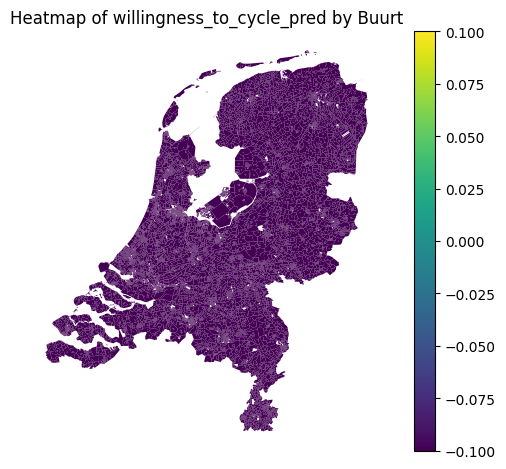

c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf = gdf.fillna(0)


<Figure size 1000x1000 with 0 Axes>

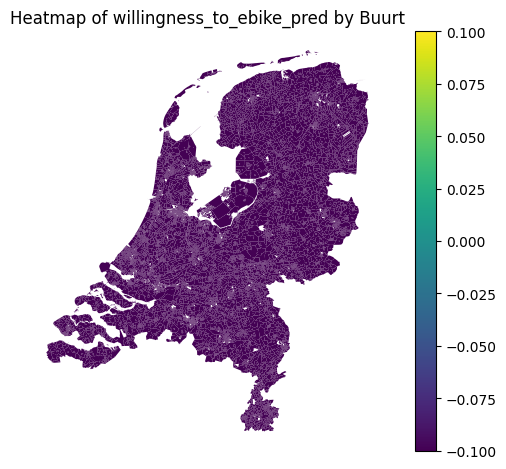

c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation\codebase\plotting\plots.py:77: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf = gdf.fillna(0)


<Figure size 1000x1000 with 0 Axes>

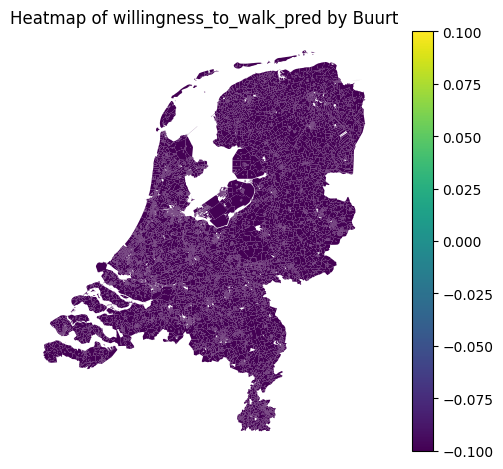

In [75]:
for col in [col_cycle_pred, col_ebike_pred, col_walk_pred]:
    plot_value_by_buurt_heatmap(
        demographics_with_predictions,
        col_name=col,
        # title=f"Willingness to {col.replace('willingness_to_', '').capitalize()} by Buurt according to Transferable Model",
        savename=f"graphics/classification_results/multiclass/transferable_{col}.png",
    )
    plt.show()